In [15]:
from torch import nn

class ConvRelu(nn.Module):
    def __init__(self, *args, **kwargs):
        super(ConvRelu, self).__init__()
        self.conv = nn.Conv2d(*args, **kwargs)
        self.relu = nn.ReLU()
        nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        nn.init.zeros_(self.conv.bias)

    def forward(self, x):
        return self.relu(self.conv(x))


class LinerRelu(nn.Module):
    def __init__(self, *args, dropout=0.5, **kwargs):
        super(LinerRelu, self).__init__()
        self.lin = nn.Linear(*args, **kwargs)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        nn.init.xavier_normal_(self.lin.weight)
        nn.init.zeros_(self.lin.bias)

    def forward(self, x):
        return self.dropout(self.relu(self.lin(x)))

In [16]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.c1 = ConvRelu(1, 96, kernel_size=11, stride=4)
        self.p1 = nn.MaxPool2d(3, 2)
        self.c2 = ConvRelu(96, 256, kernel_size=5, padding=2)
        self.p2 = nn.MaxPool2d(3, 2)
        self.c3 = ConvRelu(256, 384, kernel_size=3, padding=1)
        self.c4 = ConvRelu(384, 384, kernel_size=3, padding=1)
        self.c5 = ConvRelu(384, 256, kernel_size=3, padding=1)
        self.p3 = nn.MaxPool2d(3, 2)
        self.flatten = nn.Flatten()
        self.l1 = LinerRelu(6 * 6 * 256, 4096)
        self.l2 = LinerRelu(4096, 4096)
        self.l3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = self.p1(self.c1(x))
        x = self.p2(self.c2(x))
        x = self.p3(self.c5(self.c4(self.c3(x))))
        x = self.flatten(x)
        x = self.l3(self.l2(self.l1(x)))
        return x

In [17]:
from torchinfo import summary
model = AlexNet()
summary(model, (1, 1, 227, 227))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 10]                   --
├─ConvRelu: 1-1                          [1, 96, 55, 55]           --
│    └─Conv2d: 2-1                       [1, 96, 55, 55]           11,712
│    └─ReLU: 2-2                         [1, 96, 55, 55]           --
├─MaxPool2d: 1-2                         [1, 96, 27, 27]           --
├─ConvRelu: 1-3                          [1, 256, 27, 27]          --
│    └─Conv2d: 2-3                       [1, 256, 27, 27]          614,656
│    └─ReLU: 2-4                         [1, 256, 27, 27]          --
├─MaxPool2d: 1-4                         [1, 256, 13, 13]          --
├─ConvRelu: 1-5                          [1, 384, 13, 13]          --
│    └─Conv2d: 2-5                       [1, 384, 13, 13]          885,120
│    └─ReLU: 2-6                         [1, 384, 13, 13]          --
├─ConvRelu: 1-6                          [1, 384, 13, 13]          --
│

In [22]:
class AlexNetSmall(nn.Module):
    def __init__(self, dropout=0.5):
        super(AlexNetSmall, self).__init__()
        self.c1 = ConvRelu(1, 96, kernel_size=11, stride=4)
        self.p1 = nn.MaxPool2d(3, 2)
        self.c2 = ConvRelu(96, 256, kernel_size=5, padding=2)
        self.p2 = nn.MaxPool2d(3, 2)
        self.c3 = ConvRelu(256, 384, kernel_size=3, padding=1)
        self.c4 = ConvRelu(384, 384, kernel_size=3, padding=1)
        self.c5 = ConvRelu(384, 256, kernel_size=3, padding=1)
        self.p3 = nn.MaxPool2d(3, 2)
        self.flatten = nn.Flatten()
        self.l1 = LinerRelu(256, 128, dropout=dropout)
        self.l2 = LinerRelu(128, 128, dropout=dropout)
        self.l3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.p1(self.c1(x))
        x = self.p2(self.c2(x))
        x = self.p3(self.c5(self.c4(self.c3(x))))
        x = self.flatten(x)
        x = self.l3(self.l2(self.l1(x)))
        return x

In [23]:
model_small= AlexNetSmall()
summary(model_small, (1, 1, 67, 67))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNetSmall                             [1, 10]                   --
├─ConvRelu: 1-1                          [1, 96, 15, 15]           --
│    └─Conv2d: 2-1                       [1, 96, 15, 15]           11,712
│    └─ReLU: 2-2                         [1, 96, 15, 15]           --
├─MaxPool2d: 1-2                         [1, 96, 7, 7]             --
├─ConvRelu: 1-3                          [1, 256, 7, 7]            --
│    └─Conv2d: 2-3                       [1, 256, 7, 7]            614,656
│    └─ReLU: 2-4                         [1, 256, 7, 7]            --
├─MaxPool2d: 1-4                         [1, 256, 3, 3]            --
├─ConvRelu: 1-5                          [1, 384, 3, 3]            --
│    └─Conv2d: 2-5                       [1, 384, 3, 3]            885,120
│    └─ReLU: 2-6                         [1, 384, 3, 3]            --
├─ConvRelu: 1-6                          [1, 384, 3, 3]            --
│

In [24]:
%run utils.py

In [25]:
from torchvision import datasets, transforms
from utils import train_val_split

full = datasets.FashionMNIST(root='./data', train=True, download=True)
test = datasets.FashionMNIST(root='./data', train=False, download=True)
train, valid = train_val_split(full, seed=666)

print(len(train), len(valid), len(test))

50000 10000 10000


In [26]:
from utils import PackDataset

trans = transforms.Compose([transforms.Resize(size=67), transforms.ToTensor()])
train_data = PackDataset(train, transform=trans)
valid_data = PackDataset(valid, transform=trans)
test_data = PackDataset(test, transform=trans)

image, label = train_data[0]
print(image.size())

torch.Size([1, 67, 67])


In [27]:
from skorch.callbacks import EarlyStopping, Checkpoint, EpochScoring, LRScheduler, ProgressBar
from torch.optim.lr_scheduler import CosineAnnealingLR

def control_callbacks(
        epochs, show_bar=True,
        model_name='best_model.pt', check_dir='./data/checkpoints'
    ):
    bar = ProgressBar()
    lr_scheduler = LRScheduler(policy=CosineAnnealingLR, T_max=epochs)
    early_stopping = EarlyStopping(monitor='valid_acc', lower_is_better=False, patience=6)
    train_acc = EpochScoring(name='train_acc', scoring='accuracy', on_train=True)
    check_point = Checkpoint(
        dirname=check_dir, f_params=model_name,
        monitor='valid_acc_best', load_best=True
    )
    calls = []
    if show_bar:
        calls.append(bar)
    calls.extend([lr_scheduler, early_stopping, train_acc, check_point])
    return calls

In [31]:
import torch
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split

epochs = 50
calls = control_callbacks(epochs, check_dir='./data/alex-checkpoints', show_bar=False)
net = NeuralNetClassifier(
    AlexNetSmall,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    lr=0.001,
    batch_size=2048,
    max_epochs=epochs,
    train_split=predefined_split(valid_data),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    callbacks=calls,
    classes=list(range(10)),
)

In [32]:
net.fit(X=train_data, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      lr      dur
-------  -----------  ------------  -----------  ------------  ----  ------  -------
      1       0.2892        1.8892       0.6446        1.0023     +  0.0010  13.8579
      2       0.6034        1.0463       0.7323        0.6546     +  0.0010  14.0291
      3       0.7059        0.7554       0.7812        0.5397     +  0.0010  13.8439
      4       0.7485        0.6416       0.7905        0.5469     +  0.0010  13.8681
      5       0.7699        0.5992       0.8230        0.4644     +  0.0010  14.0731
      6       0.8113        0.5100       0.8482        0.4204     +  0.0010  13.8848
      7       0.8411        0.4502       0.8605        0.3834     +  0.0010  14.0355
      8       0.8580        0.4071       0.8644        0.3682     +  0.0010  13.8812
      9       0.8738        0.3705       0.8875        0.3233     +  0.0009  13.9995
     10       0.8810        0.3477       0.8719        0.3867    

,module,<class '__mai...AlexNetSmall'>
,criterion,<class 'torch...sEntropyLoss'>
,train_split,functools.par...7f2740fbd8a0>)
,classes,"[0, 1, ...]"
,optimizer,<class 'torch...im.adam.Adam'>
,lr,0.001
,max_epochs,50
,batch_size,2048
,iterator_train,<class 'torch...r.DataLoader'>
,iterator_valid,<class 'torch...r.DataLoader'>
,dataset,<class 'skorc...aset.Dataset'>


In [33]:
import matplotlib.pyplot as plt

def plot_history(net):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.plot(net.history[:, 'train_loss'], label='Train Loss', linewidth=3)
    ax1.plot(net.history[:, 'valid_loss'], label='Valid Loss', linewidth=3)
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.set_title('Training & Validation Loss', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax1.legend()

    ax2.plot(net.history[:, 'train_acc'], label='Train Accuracy', linewidth=3)
    ax2.plot(net.history[:, 'valid_acc'], label='Valid Accuracy', linewidth=3)
    ax2.set_xlabel('Epoch', fontsize=14)
    ax2.set_ylabel('Accuracy (%)', fontsize=14)
    ax2.set_title('Validation Accuracy', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax2.legend()

    plt.tight_layout() 
    plt.show()

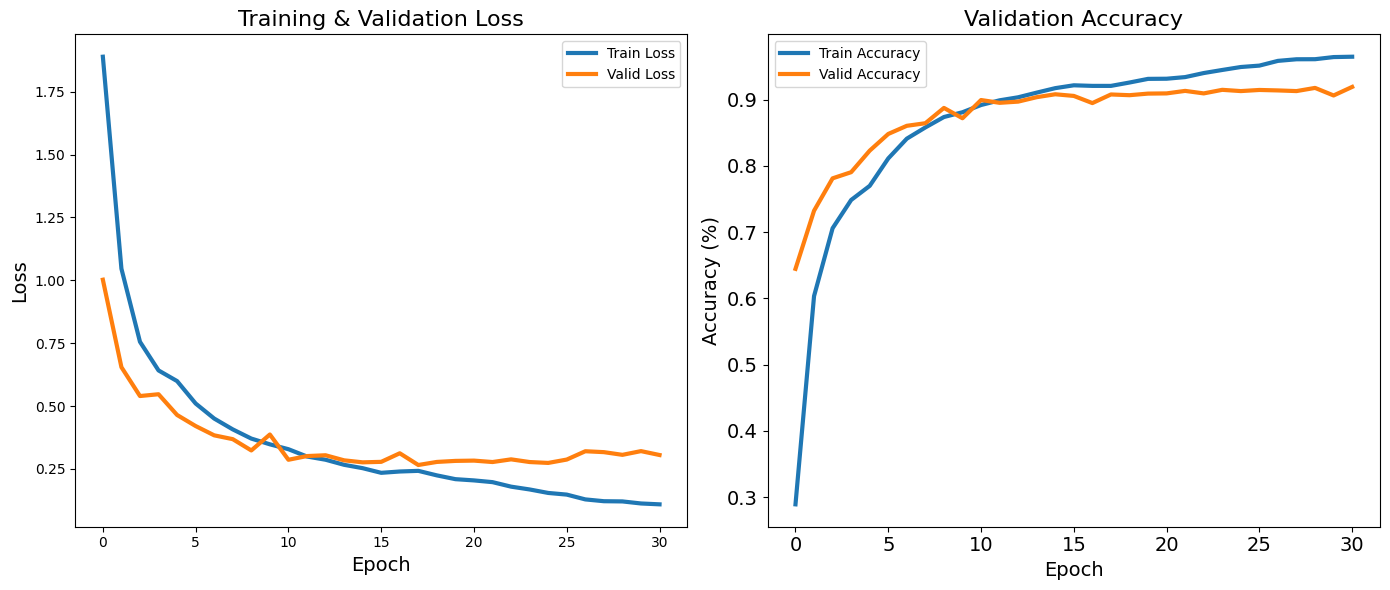

In [34]:
plot_history(net)

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def check_result(net, test_data):
    y_pred = net.predict(test_data) 
    y_prob = net.predict_proba(test_data) 
    y_true = np.array([y for x, y in iter(test_data)])     
    test_accuracy = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print('='*100)

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap="Blues",
        annot_kws={"size": 10},
    )
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.title("Confusion Matrix (Test Set)", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    print('='*100)
    y_hat = np.asarray(y_true)                 
    wrong_idx = np.where(y_pred != y_hat)[0]
    error_list = []
    for i in wrong_idx:
        features, _ = test_data[i]                  
        error_list.append({
            "features": features,              
            "true_label": int(y_hat[i]),
            "pred_label": int(y_pred[i]),
            "probabilities": y_prob[i]      
        })

    print(f'error number: {len(error_list)}')
    return error_list

Test Accuracy: 0.9160
Confusion Matrix:
 [[845   0  13  29   2   1 103   0   7   0]
 [  4 980   0  13   0   0   2   0   1   0]
 [ 20   0 873  13  53   0  41   0   0   0]
 [  9   1   8 943  16   0  23   0   0   0]
 [  0   1  65  37 850   0  45   0   2   0]
 [  0   0   0   0   0 988   0   8   0   4]
 [ 80   2  61  27  61   0 764   0   5   0]
 [  0   0   0   0   0  11   0 976   0  13]
 [  4   0   1   1   5   1   3   2 983   0]
 [  0   0   1   0   0   5   0  36   0 958]]


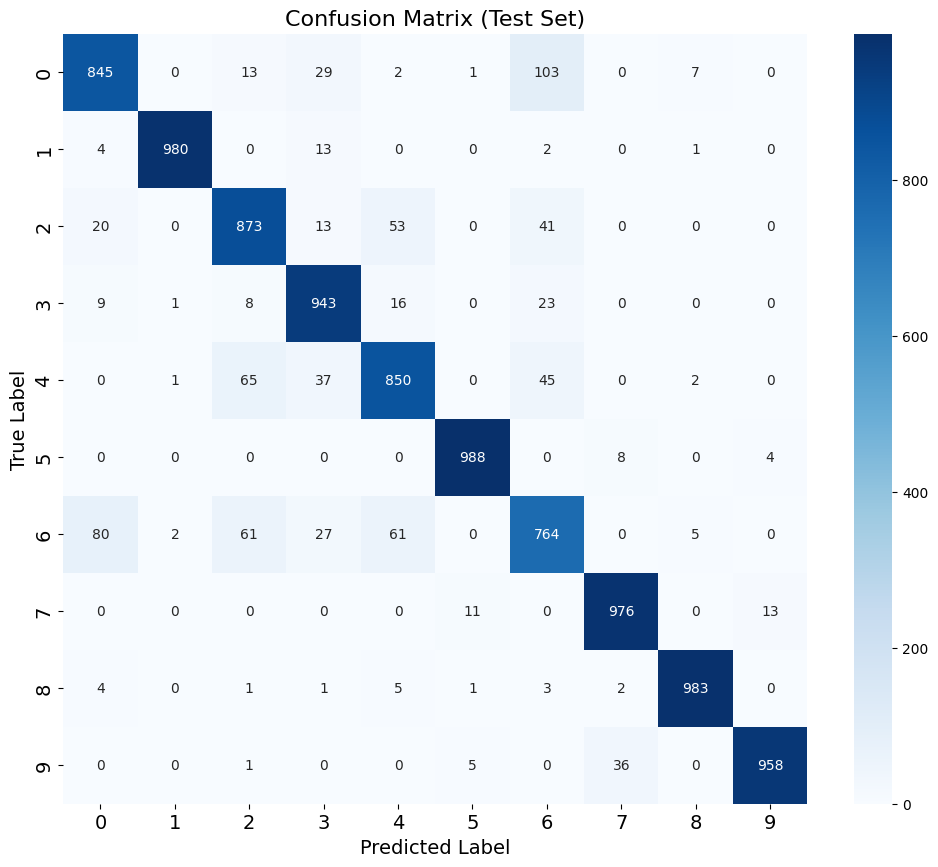

error number: 840


[{'features': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  'true_label': 7,
  'pred_label': 5,
  'probabilities': array([1.9390101e-03, 4.8704169e-04, 6.4849120e-04, 3.5509080e-04,
         1.1626690e-05, 8.0785626e-01, 4.3746135e-05, 1.7376488e-01,
         7.7865529e-04, 1.4115259e-02], dtype=float32)},
 {'features': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  'true_label': 4,
  'pred_label': 2,
  'probabilities': array([4.6914665e-06, 1.9670631e-06, 6.0415131e-01, 1.3808001e-05,
         3.7828302e-01, 5.9035951e-06, 1.7510667

In [36]:
check_result(net, test_data)

In [ ]:
import json
from sklearn.model_selection import ParameterGrid

epochs = 15
param_grid = {
    'lr': [0.01, 0.005, 0.001, 0.0005, 0.0001],
    'dropout': [0.5, 0.3, 0.2]
}

results = {
    'best_params': None,
    'best_acc': 0.0,
    'all_results': []
}

calls = control_callbacks(epochs, check_dir='./data/alex-checkpoints', show_bar=False)
for params in ParameterGrid(param_grid):
    print(f"\nTraining with params: {params}")
    alex = AlexNetSmall(params['dropout'])
    net = NeuralNetClassifier(
        alex,
        criterion=nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        lr=params['lr'],
        batch_size=2048,
        max_epochs=epochs,
        train_split=predefined_split(valid_data),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        callbacks=calls,
        classes=list(range(10)),
    )
    net.fit(X=train_data, y=None)
    valid_acc = max(net.history[:, 'valid_acc'])
    current_result = {'params': params, 'valid_acc': valid_acc}
    results['all_results'].append(current_result)

    if valid_acc > results['best_acc']:
        results['best_acc'] = valid_acc
        results['best_params'] = params

    print(f"\nBest params: {results['best_params']}, best acc: {results['best_acc']}")

with open('./data/hyperparam_results.json', 'w') as f:
    json.dump(results, f, indent=2)

In [ ]:
epochs = 70
calls = control_callbacks(epochs, check_dir='./data/alex-checkpoints')
alex = AlexNetSmall(0.3)
net = NeuralNetClassifier(
    alex,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    lr=0.0005,
    batch_size=2048,
    max_epochs=epochs,
    train_split=predefined_split(valid_data),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    callbacks=calls,
    classes=list(range(10)),
)
net.fit(X=train_data, y=None)

In [ ]:
plot_history(net)

In [ ]:
check_result(net, test_data)